In [3]:
# Predicting potential alliance shifts in a world war using graph balance theory
# Heron Ziegel
# 915986142

import numpy as np
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt

In [4]:
# Grab data from CSV adjacency matrix

# Switch df read between datasets
df = pd.read_csv('../Data/WW1.csv', index_col=0)
#df = pd.read_csv('../Data/countries.csv', index_col=0)

input_data = df.to_numpy()
column_names = df.columns

G = nx.Graph()

for j in range(input_data.shape[0]):
    for i in range(input_data.shape[0]):
        if i>j and input_data[i,j] != 0:
            G.add_edge(column_names[i], column_names[j], weight= input_data[i,j])

print(input_data)
print(G)

[[ 0 -1 -1  0  0 -1]
 [-1  0  0  0 -1 -1]
 [-1  0  0  0 -1 -1]
 [ 0  0  0  0  1  1]
 [ 0 -1 -1  1  0  1]
 [-1 -1 -1  1  1  0]]
Graph with 6 nodes and 10 edges


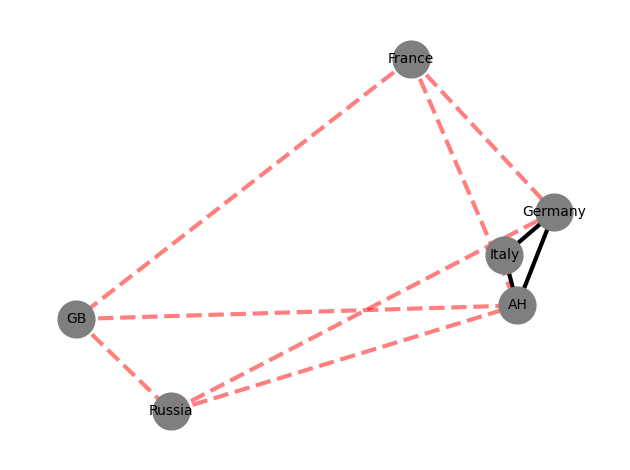

In [5]:
# Visualize initial graph

# Generate the node labels
labeldict = {}
for i in range(0, len(column_names)):
    labeldict[i] = column_names[i]

# Separate into positive and negative edges
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 1]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == -1]

pos = nx.spring_layout(G, seed=1)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="tab:gray")

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=3)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=3, alpha=0.5, edge_color="r", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
# Generate list of triangles, label balanced (1) or unbalanced (-1)
triangle_types={}

def triangles(): 
    triangles = [c for c in nx.cycle_basis(G) if len(c)==3]
    for triangle in triangles:
        tri=nx.subgraph(G,triangle)
        #take the product of the edge relationships. If there are an odd number of -1s, the triangle is unbalanced.
        triangle_types[tuple(tri.nodes())]=np.product([x[2]['weight'] for x in tri.edges(data=True)])
        
triangles()
print(triangle_types)

# Number of triangles in a fully connected graph = n(n-1)(n-2) / 6
n = G.number_of_nodes()
num_triangles = (n*(n-1)*(n-2))/6

# Returns the structural balance of the overall graph
def structural_balance():
    return sum(triangle_types.values())/num_triangles

print()
print("Structural balance: ", structural_balance())

{('AH', 'Germany', 'Italy'): 1, ('GB', 'Russia', 'AH'): -1, ('Russia', 'AH', 'Germany'): 1, ('France', 'GB', 'AH'): -1, ('France', 'AH', 'Germany'): 1}

Structural balance:  0.05


In [69]:
# Main Logic

